In [ ]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import textwrap
from IPython.display import clear_output
import numpy as np
from ipywidgets import Button, HTML, Output
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
INPUT_PATH = "data/df_30topics_intermed.csv"
RATER = "Quirin"

In [16]:
def lda_sample_and_rate(df_topics, topic_id,  prob_range = (0.25, 0.45), n = 100, seed = 42):
    """
    For determining thresholds
    Randomly sample items whose probability is within [lower_prob, upper_prob],
    collect manual ratings (1 = belongs, 0 = not).
    Returns a DataFrame with columns ['probability', 'rating'] of length n (or fewer if not enough speeches).
    """
    lower_prob, upper_prob = prob_range
    prob_col = f"topic_{topic_id}"
    candidates = df_topics[(df_topics[prob_col] >= lower_prob) & (df_topics[prob_col] <= upper_prob)]
    
    sampled = candidates.sample(n=min(n, len(candidates)), random_state=seed).reset_index(drop=True)
    ratings = []

    current_index = [0]  # Use list to modify in nested function
    
    print(f"\n{'='*90}")
    print(f"Starting manual rating: {len(sampled)} speeches to rate.")
    print(f"{'='*90}\n")
    
    output = Output()
    display(output)
    
    def show_speech(index):
        with output:
            output.clear_output(wait=True)
            if index >= len(sampled):
                print(f"Rating complete! Rated {len(ratings)}/{len(sampled)} speeches.")
                # Now add ratings to dataframe
                sampled.loc[:len(ratings)-1, 'rating'] = ratings
                print(f"\nFinal ratings: {ratings}")
                return
            
            row = sampled.iloc[index]
            print(f"Progress: {index}/{len(sampled)} speeches rated")
            print(f"\nSpeech {index}/{len(sampled)} | Year: {row['year']} | Party block: {row['party_block']}")
            print(f"Topic probability: {row[prob_col]:.4f}")
            print(textwrap.fill(row["translatedText"], width=90))
    
    def on_button_click(_button, rating_value):
        ratings.append(rating_value)
        sampled.loc[current_index[0], 'rating'] = rating_value
        current_index[0] += 1
        show_speech(current_index[0])
    
    btn_correct = Button(description="1: Correct topic")
    btn_incorrect = Button(description="0: Incorrect topic")
    
    btn_correct.on_click(lambda b: on_button_click(b, 1))
    btn_incorrect.on_click(lambda b: on_button_click(b, 0))
    
    show_speech(0)
    display(btn_correct, btn_incorrect)
    
    # Return the sampled dataframe 
    return sampled

In [ ]:
# set working directory to project root
os.chdir(os.path.dirname(os.path.dirname(os.path.dirname(os.path.abspath("__file__")))))

In [ ]:
# import topic probability data
df = pd.read_csv(INPUT_PATH)

In [ ]:
prob_range=(0.2, 0.4)
topic_id = 

In [ ]:
ratings = lda_sample_and_rate(df, topic_id=topic_id, prob_range=prob_range, n=100)


Starting manual rating: 20 speeches to rate.



Output()

Button(description='1: Correct topic', style=ButtonStyle())

Button(description='0: Incorrect topic', style=ButtonStyle())

In [25]:
# only keep relevant columns
ratings = ratings[[f'translatedText', f'topic_{topic_id}', 'rating']]
ratings

,translatedText,topic_29,rating
0,I voted in favor of the report on in vitro dia...,0.391861,1.0
1,"Madam President, I support medicine, I support...",0.305579,1.0
2,I voted in favour of this report on in vitro d...,0.280769,1.0
3,"Madam President, dear colleagues, 25 million b...",0.254424,1.0
4,I support the assessment of the EU's response ...,0.369463,1.0
5,It is clear that we need to have a regulation ...,0.344284,1.0
6,The report highlights the ineffectiveness in a...,0.298951,1.0
7,"Mr President, I would like to bring the House ...",0.320139,1.0
8,"(FR) Mr President, ladies and gentlemen, speak...",0.414546,1.0
9,I welcomed the Commission's proposal for a sep...,0.433744,1.0


In [ ]:
# save ratings: 
ratings.to_csv(f"tf_idf_ratings_{RATER}.csv")

In [7]:
ratings_jakob = pd.read_csv("tf_idf_ratings_Jakob.csv")
ratings_quirin = pd.read_csv("tf_idf_ratings_Quirin.csv")

In [28]:
ratings_both = [ratings]

Average correct topic rate: 0.95


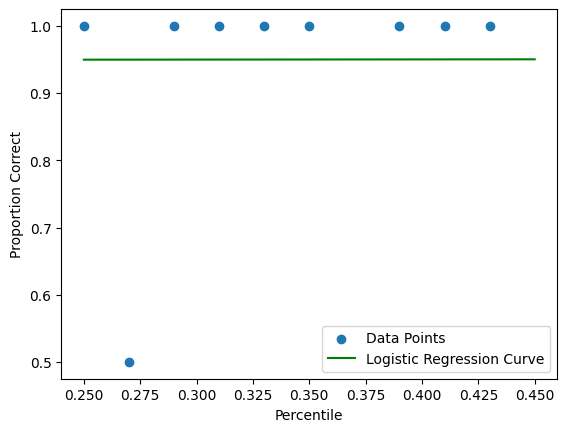

Percentile threshold for 95.0% accuracy: 0.3331832194134848


In [ ]:
# compare ratings
for ratings in ratings_both:
    # print average rejection rate
    avg_correct = ratings['rating'].mean()
    print(f"Average correct topic rate: {avg_correct:.2f}")
    # calculate mean ratings for every whole percentage step
    stepsize = 0.02
    percentile_segments = np.arange(prob_range[0], prob_range[1] + 1, stepsize)
    segment_n = len(percentile_segments)
    proportion_correct = []
    for i in range(len(percentile_segments)):
        if i == segment_n-1:
            upper_bound = percentile_segments[-1]
        else:
            lower_bound = percentile_segments[i]
            upper_bound = percentile_segments[i+1]
            segment_ratings = ratings[(ratings[f'topic_{topic_id}'] >= lower_bound) & (ratings[f'topic_{topic_id}'] < upper_bound)]
            if len(segment_ratings) > 0:
                prop_correct = segment_ratings['rating'].mean()
            else:
                prop_correct = np.nan
        proportion_correct.append(prop_correct)

    # fit logistic regression model
    # rating as categorical variable
    ratings['rating'] = ratings['rating'].astype(int)
    X = np.array(ratings[f'topic_{topic_id}']).reshape(-1, 1)
    y = np.array(ratings["rating"]).reshape(-1, 1)
    log_model = LogisticRegression()
    log_model.fit(X, y.ravel())

    # plot logistic regression curve
    plt.figure()
    plt.scatter(percentile_segments, proportion_correct, label='Data Points')
    # Generate a range of percentiles for smooth curve
    x_range = np.linspace(prob_range[0], prob_range[1], 300).reshape(-1, 1)
    # Predict probabilities using the logistic model
    y_prob = log_model.predict_proba(x_range)[:, 1]
    plt.plot(x_range, y_prob, color='green', label='Logistic Regression Curve')
    plt.xlabel('Topic Probability')
    plt.ylabel('Proportion Correct')
    plt.legend()
    plt.show()

    desired_accuracy = 0.95
    # Calculate the percentile threshold for the desired accuracy
    logit_threshold = np.log(desired_accuracy / (1 - desired_accuracy))
    coef = log_model.coef_[0][0]
    intercept = log_model.intercept_[0]
    percentile_threshold = (logit_threshold - intercept) / coef
    print(f"Topic probability threshold for {desired_accuracy*100}% accuracy: {percentile_threshold}")


In [ ]:
# combine ratings
ratings_combined = pd.concat(ratings_both, ignore_index=True)
desired_accuracy = 0.95

NameError: name 'pd' is not defined